In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [3]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [19]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict
import random
import re
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import evaluate

In [5]:
dataset = load_dataset("Yelp/yelp_review_full")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
print(dataset["train"])


Dataset({
    features: ['label', 'text'],
    num_rows: 650000
})


In [7]:
print(dataset["test"])


Dataset({
    features: ['label', 'text'],
    num_rows: 50000
})


In [8]:
def sample_data(dataset, label_column="label", n_per_class=2000, seed=42):
    random.seed(seed)
    label_buckets = defaultdict(list)

    for example in dataset:
        label_buckets[example[label_column]].append(example)

    sampled = []
    for label, examples in label_buckets.items():
        sampled.extend(random.sample(examples, min(n_per_class, len(examples))))

    return sampled

In [9]:
sampled_train = sample_data(dataset["train"], n_per_class=2000)

In [10]:
sampled_train = Dataset.from_list(sampled_train)

In [11]:
from collections import Counter
label_counts = Counter([ex['label'] for ex in sampled_train])
print("Sampled label distribution:", label_counts)

Sampled label distribution: Counter({4: 2000, 1: 2000, 3: 2000, 0: 2000, 2: 2000})


In [12]:
def clean_text(text):
    text = text.strip()
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with one
    return text


In [13]:
# Clean text
def preprocess_function(example):
    example["text"] = clean_text(example["text"])
    return example

train_dataset = sampled_train.map(preprocess_function)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [14]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Apply tokenizer
tokenized_train = train_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [15]:
print(tokenized_train[0].keys())

dict_keys(['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'])


In [16]:
# Subset the original dataset["test"] before tokenizing and passing to the trainer
sampled_test = sample_data(dataset["test"], n_per_class=1000)
sampled_test = Dataset.from_list(sampled_test)
test_dataset = sampled_test.map(preprocess_function)

# Apply tokenizer to the entire dataset (which is a DatasetDict)
tokenized_test =test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [17]:
# tokenized_.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [20]:
# Combine into a DatasetDict
tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "test": tokenized_test
})

In [21]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [22]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"]}

In [24]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch", # Add save_strategy and set to epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True, # Load the best model when training ends
    metric_for_best_model="eval_accuracy", # Metric to monitor for early stopping
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(10000)),  # Subset for speed
    eval_dataset=tokenized_datasets["test"].select(range(2000)),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-24-762696967.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sandrabinu99 (sandrabinu99-university-of-hertfordshire) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.877800,0.841386,0.656500,0.306793


In [ ]:
results = trainer.evaluate()
print(results)


KeyboardInterrupt: 

In [ ]:
text = "The food was excellent, but the service was really slow."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to the model's device
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(dim=-1).item()
print(f"Predicted Star Rating: {predicted_class + 1} stars")

Predicted Star Rating: 3 stars


   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...
130000


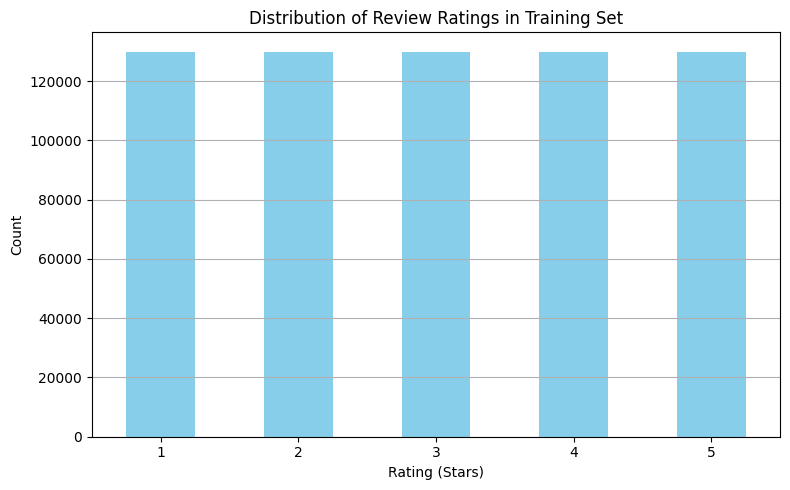

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas for visualization
train_df = dataset["train"].to_pandas()
print(train_df.head())
label_counts = train_df["label"].value_counts().sort_index()

print(label_counts[4]) # Accessing with integer key and printing value directly
# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Review Ratings in Training Set")
plt.xlabel("Rating (Stars)")
plt.ylabel("Count")
plt.xticks(ticks=range(5), labels=[1, 2, 3, 4, 5], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

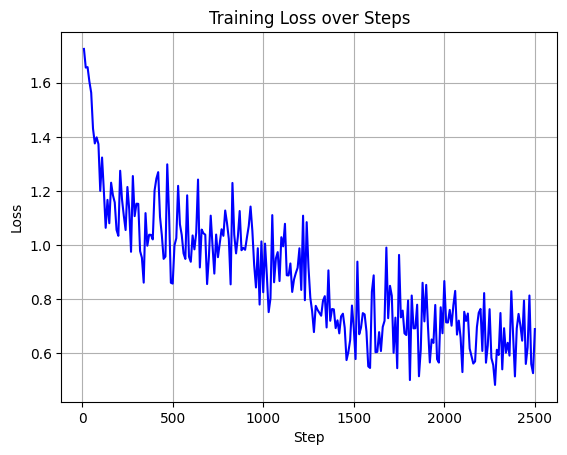

In [ ]:
# Use `trainer.state.log_history` if logging_steps is enabled
logs = pd.DataFrame(trainer.state.log_history)

# Filter for loss only
loss_logs = logs[logs['loss'].notnull()]

plt.plot(loss_logs["step"], loss_logs["loss"], label="Training Loss", color="blue")
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


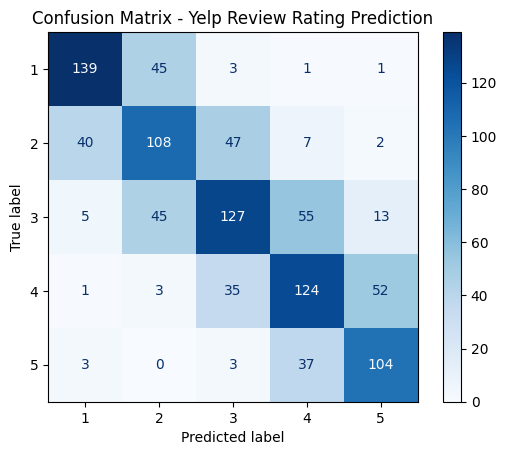

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"].select(range(1000)))
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Yelp Review Rating Prediction")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sample_indices = [10, 25, 77]
for idx in sample_indices:
    review_text = dataset["test"][idx]["text"]
    true_label = dataset["test"][idx]["label"]

    inputs = tokenizer(review_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to the model's device
    outputs = model(**inputs)
    pred_label = outputs.logits.argmax(dim=-1).item()

    print(f"Review: {review_text[:150]}...")
    print(f"True Rating: {true_label + 1}, Predicted: {pred_label + 1}")
    print("-" * 80)

Review: Think Chuck E. Cheese for adults.  Skee Ball, video games pool tables.  Clean environment.  Good fun.\n\nUnfortunately, I went for a bite to eat and i...
True Rating: 2, Predicted: 2
--------------------------------------------------------------------------------
Review: I hate this place.\nIt's very loud, the service is very poor, and the food is so-so.\nIf you want good Chinese in Pittsburgh, try China Palace (Shadys...
True Rating: 1, Predicted: 2
--------------------------------------------------------------------------------
Review: OK so another winner in this neighborhood besides Nicky's.  The Penna Parma was outstanding and the Parm crusted salmon over whole wheat artichoke rav...
True Rating: 5, Predicted: 5
--------------------------------------------------------------------------------


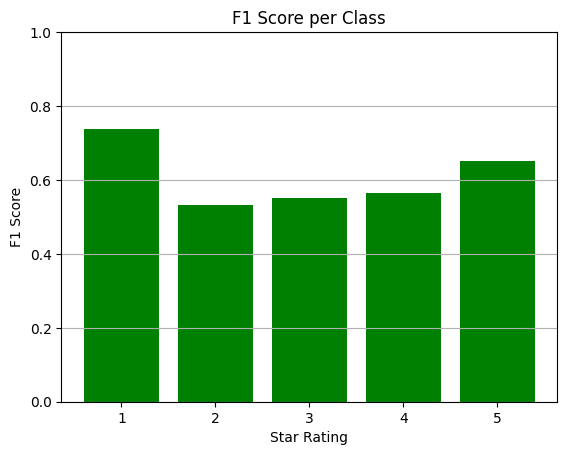

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(5)]

plt.bar([1, 2, 3, 4, 5], f1_scores, color='green')
plt.title("F1 Score per Class")
plt.xlabel("Star Rating")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
